<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/biogpt_patent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q
!pip install sacremoses -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os 
import json 
from transformers import AutoTokenizer, BioGptModel
import torch
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD

In [4]:
# os.listdir('drive/MyDrive/transfer/patent')

In [5]:
f = open ('drive/MyDrive/transfer/patent/vec_vectorized_biotech_patents_transformed_ols.json', "r")
data_biotech = json.loads(f.read())
data_biotech[0]['title']
data_abst = [data_biotech[i]['abstract'] for i in range(len(data_biotech))]
data_title = [data_biotech[i]['title'] for i in range(len(data_biotech))]

In [6]:
print(len(data_biotech))

484


In [7]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt");
model = BioGptModel.from_pretrained("microsoft/biogpt");

Some weights of the model checkpoint at microsoft/biogpt were not used when initializing BioGptModel: ['output_projection.weight']
- This IS expected if you are initializing BioGptModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BioGptModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def normalizer(x):
    return x/np.linalg.norm(x)

class BioGptModel:
    
    def __init__(self, model, tokenizer):
        # self.sentence = sentence
        self.model = model
        self.tokenizer = tokenizer

    def sentence_vectors(self,sentence):
        inputs = self.tokenizer(sentence, return_tensors = 'pt')
        w_vectors = self.model(**inputs)

        # return w_vectors
        token_embeddings = w_vectors[0] #First element of model_output contains all token embeddings
        input_mask_expanded = inputs.attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

gpt_class = BioGptModel(model, tokenizer)

In [9]:
def sentence_encoder(data):
    vectors = []
    normalized_vectors = []
    for i in range(len(data)):
        sentence_vectors = gpt_class.sentence_vectors(data[i]).detach().numpy()
        vectors.append(sentence_vectors)
        normalized_vectors.append(normalizer(sentence_vectors))

    vectors = np.squeeze(np.array(vectors))
    normalized_vectors = np.squeeze(np.array(normalized_vectors))

    return vectors, normalized_vectors    

In [10]:
# abst_vectors, abst_vectors_norm = sentence_encoder(data_abst) 
# title_vectors, title_vectors_norm = sentence_encoder(data_abst) 

In [11]:
# np.save('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt.npy',abst_vectors)
# np.save('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt_norm.npy',abst_vectors_norm)

# np.save('drive/MyDrive/transfer/patent/data_biotech_title_biogpt.npy',title_vectors)
# np.save('drive/MyDrive/transfer/patent/data_biotech_title_biogpt_norm.npy',title_vectors_norm)

In [13]:
abst_vectors = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt.npy')
abst_vectors_norm = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt_norm.npy')

title_vectors = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt.npy')
title_vectors_norm = np.load('drive/MyDrive/transfer/patent/data_biotech_abstarct_biogpt_norm.npy')

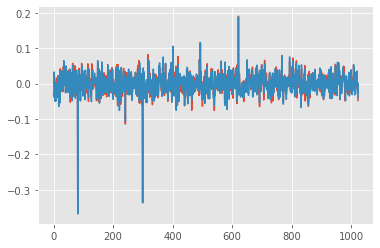

In [14]:
plt.plot(normalized_abstract_vectors[0])
plt.plot(normalized_abstract_vectors[1])

In [15]:
pca = PCA().fit(normalized_abstract_vectors)
pca_var = np.cumsum(pca.explained_variance_ratio_)

svd_content = TruncatedSVD(n_iter= 25, n_components = 1024 ).fit(normalized_abstract_vectors)
svd_var = np.cumsum(svd_content.explained_variance_ratio_)

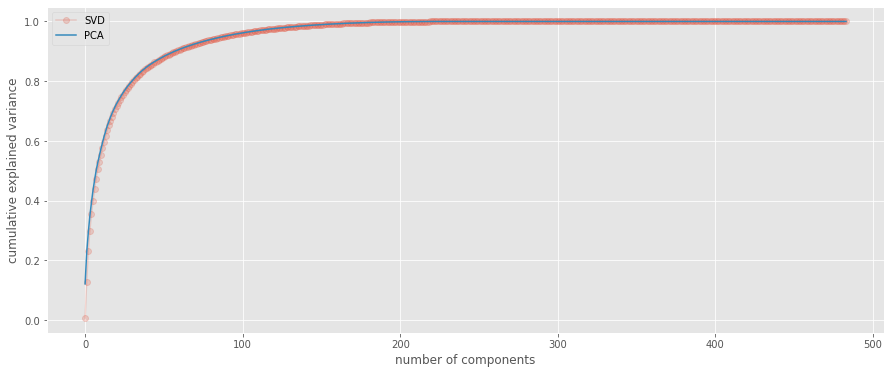

In [16]:
plt.figure(figsize = (15,6))
plt.plot(svd_var, marker = 'o', alpha =0.2)
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

# plt.figure(figsize = (15,6))
plt.plot(pca_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])

In [17]:
print('PCA 100% :',np.where(np.array(pca_var) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var) >= 0.90)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])
print('SVD 82% :',np.where(np.array(svd_var) >= 0.82)[0][0])

PCA 100% : 152
SVD 100% : 153
PCA 95% : 89
SVD 95% : 89
PCA 90% : 57
SVD 90% : 58
SVD 82% : 34
SVD 82% : 34
